In [1]:
# gurobi free license only supports 2000 linear constraints, for higher n a (academic) license is needed
import gurobipy as gp
import numpy as np
from gurobipy import GRB
import matplotlib.pyplot as plt
import string
import matplotlib
import seaborn as sns

In [2]:
def createmodel(n: int, piece: str):
    
    # set up the basic model
    model = gp.Model('nqueens')
    model.params.LogToConsole = 0 
    squares = model.addMVar((n, n), vtype=GRB.BINARY, name="x")
    model.setObjective(squares.sum(), GRB.MAXIMIZE)
    
    # add constraints depending on the possible moves of the chosen piece
    
    # row and file constrains
    if piece=="queen" or piece=="rook" or piece=="superqueen":
        for i in range(n):
            model.addConstr(squares[:, i].sum() <= 1)
            model.addConstr(squares[i, :].sum() <= 1)
    
    # diagonal constraints
    if piece=="queen" or piece=="superqueen" or piece=="bishop":
        model.addConstrs(gp.quicksum(squares[i, j] for i in range(n) for j in range(n) if i - j == k) <= 1 for k in range(-n + 1, n - 1))
        model.addConstrs(gp.quicksum(squares[i, j] for i in range(n) for j in range(n) if i + j == k) <= 1 for k in range(2 * n - 1))
    
    # knight moves (only 4/8 necessary because of symmetry)
    if piece=="superqueen" or piece=="knight" or piece=="gnu":
        for i in range(0,n-1):
            model.addConstrs(squares[i,j]+squares[i+1,j+2] <=1 for j in range(0,n-2))
        for i in range(0,n-1):    
            model.addConstrs(squares[i,j]+squares[i+1,j-2] <=1 for j in range(2,n))
        for i in range(2,n):
            model.addConstrs(squares[i,j]+squares[i-2,j+1] <=1 for j in range(0,n-1))
        for i in range(2,n):
            model.addConstrs(squares[i,j]+squares[i-2,j-1] <=1 for j in range(1,n))
    
    # exemplary fair knight moves
    if piece=="grasshopper" or piece=="gnu":
        for i in range(0,n-1):
            model.addConstrs(squares[i,j]+squares[i+1,j+3] <=1 for j in range(0,n-3))
        for i in range(0,n-1):    
            model.addConstrs(squares[i,j]+squares[i+1,j-3] <=1 for j in range(3,n))
        for i in range(3,n):
            model.addConstrs(squares[i,j]+squares[i-3,j+1] <=1 for j in range(0,n-1))
        for i in range(3,n):
            model.addConstrs(squares[i,j]+squares[i-3,j-1] <=1 for j in range(1,n))            
    
    # king moves (only 4/8 necessary because of symmetry)
    if piece=="king":
        for i in range(0,n-1):
            model.addConstrs(squares[i,j]+squares[i+1,j] <=1 for j in range(0,n))
        for i in range(0,n):    
            model.addConstrs(squares[i,j]+squares[i,j+1] <=1 for j in range(0,n-1))
        for i in range(0,n-1):
            model.addConstrs(squares[i,j]+squares[i+1,j+1] <=1 for j in range(0,n-1))
        for i in range(1,n):
            model.addConstrs(squares[i,j]+squares[i-1,j+1] <=1 for j in range(0,n-1))        
        
    model.params.PoolSearchMode = 0  
    model.params.PoolSolutions = 10**6
    model.params.PoolGap = 0  
    return(model, squares)

In [5]:
def solve(n: int, model, squares, mode: int):
    model.params.LogToConsole = 0   
    model.optimize()
    
    if mode == 1:
        
        image = np.zeros(n*n)
        image = image.reshape((n, n))
        row_labels = range(n)
        col_labels = list(string.ascii_uppercase[0:n])
        if n > 26:
            col_labels = range(n)

        for i in range(n):
            for j in range(n):
                if (i+j)%2 == 0:
                    image[i,j] = 0.5
                if squares.X[i,j] == 1:
                    image[i,j] = squares.X[i,j]+0.5
        plt.figure(figsize=(10,10))
        plt.matshow(image, fignum=1)
        plt.xticks(range(n), col_labels)
        plt.yticks(range(n), row_labels)
        plt.show()
        print('Pieces placed: %g' % model.objVal)

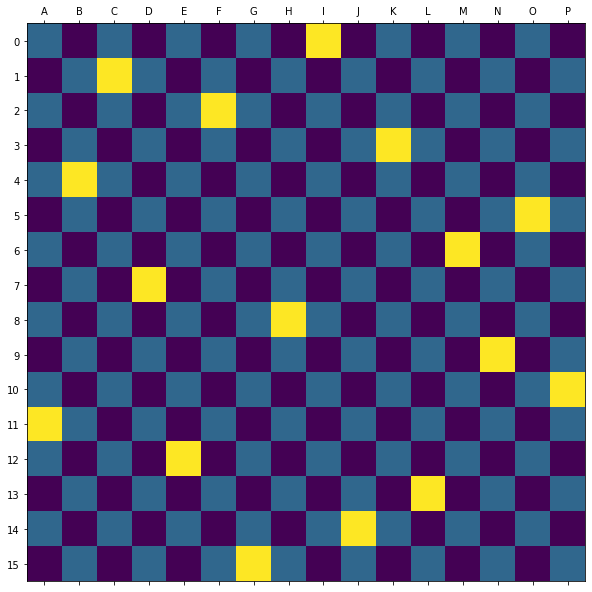

Pieces placed: 16


In [6]:
# example 
# possible pieces are rook, bishop, queen, knight
# superqueen (queen + knight)
# gnu (knight + camel)

# set size of the nxn board
n = 16 

# define model for the chosen piece
model, squares = createmodel(n, "queen")

# solve and plot one optimal solution
solve(n, model, squares, 1)

0.0
0.0
0.0
0.0010013580322265625
0.001003265380859375
0.0
0.0020046234130859375
0.002033233642578125
0.0019779205322265625
0.00200653076171875
0.0040111541748046875
0.0030078887939453125
0.004009246826171875
0.006046295166015625
0.006015777587890625
0.006015777587890625
0.009046554565429688
0.009023666381835938
0.0130615234375
0.012004852294921875
0.012058258056640625
0.016040802001953125
0.022039413452148438
0.01807403564453125
0.02208709716796875
0.028074264526367188
0.030080795288085938
0.030076980590820312
0.0310821533203125
0.04011344909667969
0.046115875244140625
0.04910087585449219
0.025066375732421875
0.05715179443359375
0.031078338623046875
0.029079437255859375
0.031078338623046875
0.032085418701171875
0.03108978271484375
0.038082122802734375
0.04010772705078125
0.03810882568359375
0.04213142395019531
0.03912353515625
0.0441436767578125
0.04913902282714844
0.16646957397460938
0.04408836364746094
0.051136016845703125
0.053142547607421875
0.21961021423339844
0.05511856079101562

<AxesSubplot:>

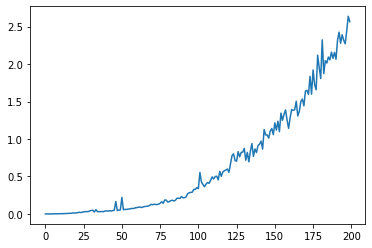

In [19]:
# runs the instances from n=0 to k and saves the results and runtimes
k = 200
runtime = np.zeros((k,2))
for i in range(k):
    model, squares = createmodel(i)
    model.params.LogToConsole = 0
    solve(i, model, squares, 0)
    runtime[i,1] = model.runtime
    runtime[i,0] = i
    print(str(i)+": "+str(model.runtime))
runtime  
sns.lineplot(y=runtime[:,1], x=runtime[:,0])

In [ ]:
# further runs, partially terminated
l = 1
k = 2000
runtime = np.zeros((k,2))
for i in range(l,k):
    model, squares = createmodel(i)
    model.params.LogToConsole = 0
    solve(i, model, squares, 0)
    runtime[i,1] = model.runtime
    runtime[i,0] = i
    print(str(i)+": "+str(model.runtime))
runtime  
sns.lineplot(y=runtime[:,1], x=runtime[:,0])

0: 0.001003265380859375
1: 0.0
2: 0.0
3: 0.0010223388671875
4: 0.0020046234130859375
5: 0.001003265380859375
6: 0.00102996826171875
7: 0.0019855499267578125
8: 0.00200653076171875
9: 0.0020046234130859375
10: 0.0030059814453125
11: 0.0030078887939453125
12: 0.0040111541748046875
13: 0.0050220489501953125
14: 0.008020401000976562
15: 0.006015777587890625
16: 0.008026123046875
17: 0.0080413818359375
18: 0.014039993286132812
19: 0.012002944946289062
20: 0.012025833129882812
21: 0.018045425415039062
22: 0.023088455200195312
23: 0.0180206298828125
24: 0.022058486938476562
25: 0.028074264526367188
26: 0.031055450439453125
27: 0.034091949462890625
28: 0.033115386962890625
29: 0.047130584716796875
30: 0.050128936767578125
31: 0.04911231994628906
32: 0.02707672119140625
33: 0.06317901611328125
34: 0.0310821533203125
35: 0.030078887939453125
36: 0.031084060668945312
37: 0.031084060668945312
38: 0.031084060668945312
39: 0.03305625915527344
40: 0.037097930908203125
41: 0.03208351135253906
42: 0.04

348: 14.480484008789062
349: 42.200260162353516
350: 18.9714298248291
351: 32.104400634765625
352: 40.54081344604492
353: 50.48830604553223
354: 59.6205997467041
355: 22.48781967163086
356: 29.33503532409668
357: 33.600385665893555
358: 19.305355072021484
359: 58.35723876953125
360: 58.73824119567871
361: 24.504182815551758
362: 49.603952407836914
363: 55.38332557678223
364: 69.07475280761719
365: 50.627655029296875
366: 53.397043228149414
367: 67.92268562316895
368: 12.483192443847656
369: 71.67964172363281
370: 75.54198265075684
371: 37.042503356933594
372: 61.90069389343262
373: 71.10713386535645
374: 40.385393142700195
375: 78.98711585998535
376: 64.21277618408203
377: 60.29984474182129
378: 72.61316108703613
379: 54.66742515563965
380: 59.875288009643555
381: 87.84869003295898
382: 27.729759216308594
383: 37.90282440185547
384: 53.974578857421875
385: 28.64322280883789
386: 55.422428131103516
387: 62.50527000427246
388: 93.32425689697266
389: 37.09169578552246
390: 146.74138259887

In [7]:
l = 1
k = 2000
runtime = np.zeros((k,2))
for i in range(l,k):
    model, squares = createmodel(i*10)
    model.params.LogToConsole = 0
    solve(i, model, squares, 0)
    runtime[i,1] = model.runtime
    runtime[i,0] = i*10
    print(str(i*10)+": "+str(model.runtime))
runtime  
sns.lineplot(y=runtime[:,1], x=runtime[:,0])

10: 0.0040111541748046875
20: 0.014039993286132812
30: 0.046112060546875
40: 0.03612709045410156
50: 0.2145709991455078
60: 0.08020782470703125
70: 0.11729049682617188
80: 0.15839385986328125
90: 0.21754837036132812
100: 0.34390830993652344
110: 0.4261341094970703
120: 0.554473876953125
130: 0.7700214385986328
140: 0.9304943084716797
150: 1.2653446197509766
160: 1.2132244110107422
170: 1.5390968322753906
180: 1.6433391571044922
190: 1.923116683959961
200: 2.402385711669922
210: 2.6099071502685547
220: 3.021059036254883
230: 3.8051490783691406
240: 4.3646087646484375
250: 5.074489593505859
260: 5.762355804443359
270: 8.282032012939453
280: 7.688446044921875
290: 9.605583190917969
300: 49.16073989868164
310: 15.307756423950195
320: 8.560783386230469
330: 30.0218505859375
340: 50.36196517944336
350: 17.218795776367188
360: 52.88869094848633
370: 66.90902519226074
380: 55.71319770812988
390: 140.47568321228027
400: 24.077058792114258
410: 37.50473976135254
420: 95.49205207824707
430: 77.82

KeyboardInterrupt: 

<AxesSubplot:>

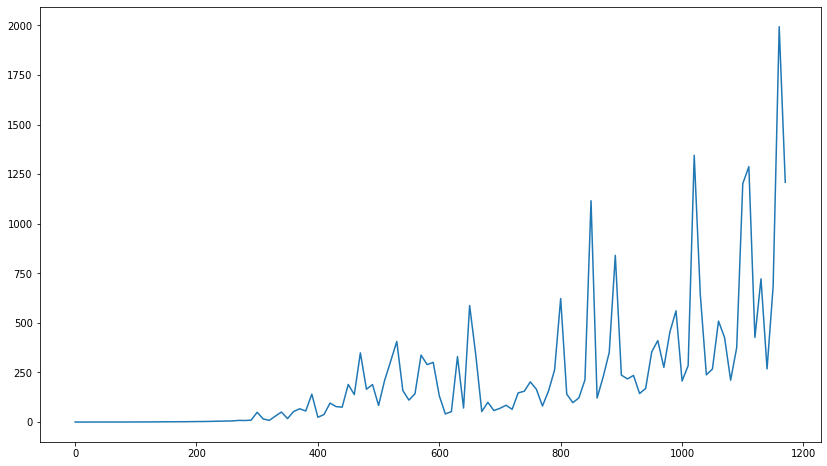

In [11]:
#plot of the runtime for high instances
plt.figure(figsize=(14,8))
sns.lineplot(y=runtime[:,1], x=runtime[:,0])

Number of solutions found: 73712


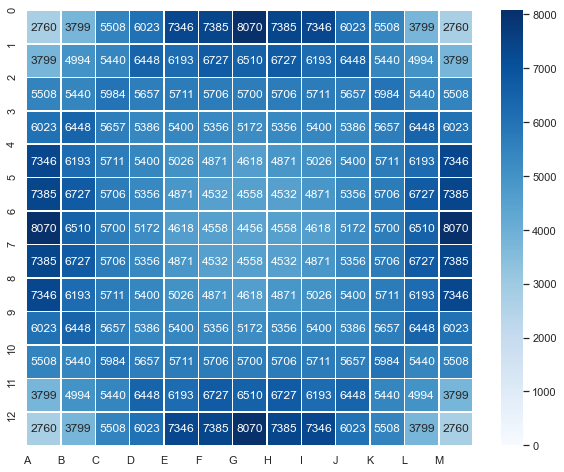

Queens placed: 13


In [17]:
# observing pattern of queen placements

n=13

model, squares = createmodel(n, "queen")
model.params.LogToConsole = 0
model.params.PoolSearchMode = 2
model.optimize()

sumat = np.zeros(n*n)

nSolutions = model.SolCount
print('Number of solutions found: ' + str(nSolutions))
for sol in range(nSolutions):
    model.setParam(GRB.Param.SolutionNumber, sol)
    sumat = sumat + model.Xn
    
#image = np.zeros(n*n)
sumat = sumat.reshape((n, n))
row_labels = range(n)
col_labels = list(string.ascii_uppercase[0:n])
if n > 26:
    col_labels = range(n)
sns.set(rc = {'figure.figsize':(10,8)})
sns.heatmap(sumat.astype(int), linewidths=.5, cmap="Blues", annot=True, fmt="d", vmin=0, vmax=sumat.max())
plt.xticks(range(n), col_labels)
plt.yticks(range(n), row_labels)
plt.show()
print('Queens placed: %g' % model.objVal)